In [1]:
!nvidia-smi

Tue Apr  9 19:15:21 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.86                 Driver Version: 551.86         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2070 ...  WDDM  |   00000000:05:00.0  On |                  N/A |
| 20%   30C    P8             11W /  215W |    1083MiB /   8192MiB |      9%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Classifying Disaster-Related Tweets as Real or Fake

We're interested in monitoring and analyzing news on social media platforms to look for misinformation. One such platform that has proven to become an important communication channel in times of emergency is *X* (formerly known as Twitter).

We've been tasked with building a **deep learning text classification model** that predicts which "Tweets" are about real disasters and which aren't.

We'll be loading our dataset 

## Loading the Data

In [1]:
import string
import os


# visuals
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# machine learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SpatialDropout1D, Input, TextVectorization, Embedding, LSTM, Dense, Bidirectional, Dropout, Activation
from tensorflow.keras.regularizers import L1, L2, L1L2
from tensorflow.keras.optimizers import Adam, RMSprop

# transfer learning
import transformers
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification

In [32]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [46]:
train_df = pd.read_csv('..\\artifacts\\04_11_2024_13_03_43\DataIngestionArtifacts\\train.csv') 

In [4]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train_df.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


## Exploratory Data Analysis (EDA)

In this section, we delve into the heart of our project: **analyzing the data**.

We’ll analyze the data and perform necessary cleaning as we go along.

In [7]:
train_df.shape

(7613, 5)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In reality, columns `id`, `keyword`, and `location` don't provide much information. Coupled with the fact that two of the columns have missing values (`keyword` and `location`), we'll move forward with our analysis without them.  

In [47]:
train_df.drop(['id', 'keyword', 'location'], inplace=True, axis=1)

In [10]:
train_df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [48]:
train_df['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [12]:
round(train_df['target'].value_counts(normalize=True)*100, 2)

target
0    57.03
1    42.97
Name: proportion, dtype: float64

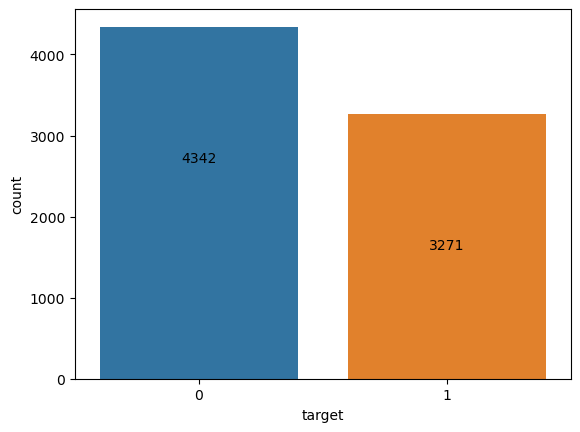

In [71]:
ax = sns.countplot(x='target', data=train_df)
ax.bar_label(ax.containers[0], padding=-100)
# # Add count values as labels
# for p in graph.patches:
#     height = p.get_height()
#     label_count = train_df['target'].value_counts()[p.get_children()]
#     graph.text(p.get_x() + p.get_width() / 2., height + 0.1,label_count, ha="center")

plt.show()

57% of the Tweets are labeled `0` (non-disaster) and around 43% as `1` (actual disaster). 

## Text Preprocessing

Preprocessing is crucial for preparing the tweet text for analysis and machine learning tasks. We'll restructure the text with the following points in mind: 

- **Formatting**: Standardize the text format for consistency.
- **Cleaning**: Remove noise such as special characters, URLs, and irrelevant punctuation.
- **Tokenization**: Break down the text into individual words or tokens.
- **Further Steps**: Apply additional processing like stemming or lemmatization if necessary.

In [14]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cisco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cisco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cisco\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\cisco\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Formatting

In [15]:
#lower string characters
train_df['text'] = train_df['text'].str.lower()
train_df['text'].head()

0    our deeds are the reason of this #earthquake m...
1               forest fire near la ronge sask. canada
2    all residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    just got sent this photo from ruby #alaska as ...
Name: text, dtype: object

### Cleaning

In [16]:
def punctuation(inputs):
  return re.sub(r'[^a-zA-Z]', ' ', inputs)

train_df['text'] = train_df['text'].apply(punctuation)
train_df.head()

,text,target
0,our deeds are the reason of this earthquake m...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are ...,1
3,people receive wildfires evacuation or...,1
4,just got sent this photo from ruby alaska as ...,1


### Tokenization

In [17]:
def tokenization(inputs):
    return word_tokenize(inputs)

train_df['text_tokenized'] = train_df['text'].apply(tokenization)
train_df.head()

,text,target,text_tokenized
0,our deeds are the reason of this earthquake m...,1,"[our, deeds, are, the, reason, of, this, earth..."
1,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]"
2,all residents asked to shelter in place are ...,1,"[all, residents, asked, to, shelter, in, place..."
3,people receive wildfires evacuation or...,1,"[people, receive, wildfires, evacuation, order..."
4,just got sent this photo from ruby alaska as ...,1,"[just, got, sent, this, photo, from, ruby, ala..."


### Trimming with Stopwords

In [18]:
stop_words = set(stopwords.words('english'))
stop_words.remove('not')

def stopwords_remove(inputs):
    return [word for word in inputs if word not in stop_words]

train_df['text_stop'] = train_df['text_tokenized'].apply(stopwords_remove)
train_df.head()

,text,target,text_tokenized,text_stop
0,our deeds are the reason of this earthquake m...,1,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv..."
1,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,all residents asked to shelter in place are ...,1,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o..."
3,people receive wildfires evacuation or...,1,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order..."
4,just got sent this photo from ruby alaska as ...,1,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


### Lemmatization

In [19]:
lemmatizer = WordNetLemmatizer()

def lemmatization(inputs):
    return [lemmatizer.lemmatize(word=word, pos='v') for word in inputs]

train_df['text_lemmatized'] = train_df['text_stop'].apply(lemmatization)
train_df.head()

,text,target,text_tokenized,text_stop,text_lemmatized
0,our deeds are the reason of this earthquake m...,1,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[deeds, reason, earthquake, may, allah, forgiv..."
1,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,all residents asked to shelter in place are ...,1,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[residents, ask, shelter, place, notify, offic..."
3,people receive wildfires evacuation or...,1,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order..."
4,just got sent this photo from ruby alaska as ...,1,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[get, send, photo, ruby, alaska, smoke, wildfi..."


In [20]:
train_df['final'] = train_df['text_lemmatized'].str.join(' ')

train_df.head()

,text,target,text_tokenized,text_stop,text_lemmatized,final
0,our deeds are the reason of this earthquake m...,1,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv...","[deeds, reason, earthquake, may, allah, forgiv...",deeds reason earthquake may allah forgive us
1,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,all residents asked to shelter in place are ...,1,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o...","[residents, ask, shelter, place, notify, offic...",residents ask shelter place notify officer eva...
3,people receive wildfires evacuation or...,1,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order...",people receive wildfires evacuation order cali...
4,just got sent this photo from ruby alaska as ...,1,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi...","[get, send, photo, ruby, alaska, smoke, wildfi...",get send photo ruby alaska smoke wildfires pou...


## Visualizing with WordCloud

In [21]:
disaster_df = train_df[train_df['target'] == 1]
non_disaster_df = train_df[train_df['target'] == 0]

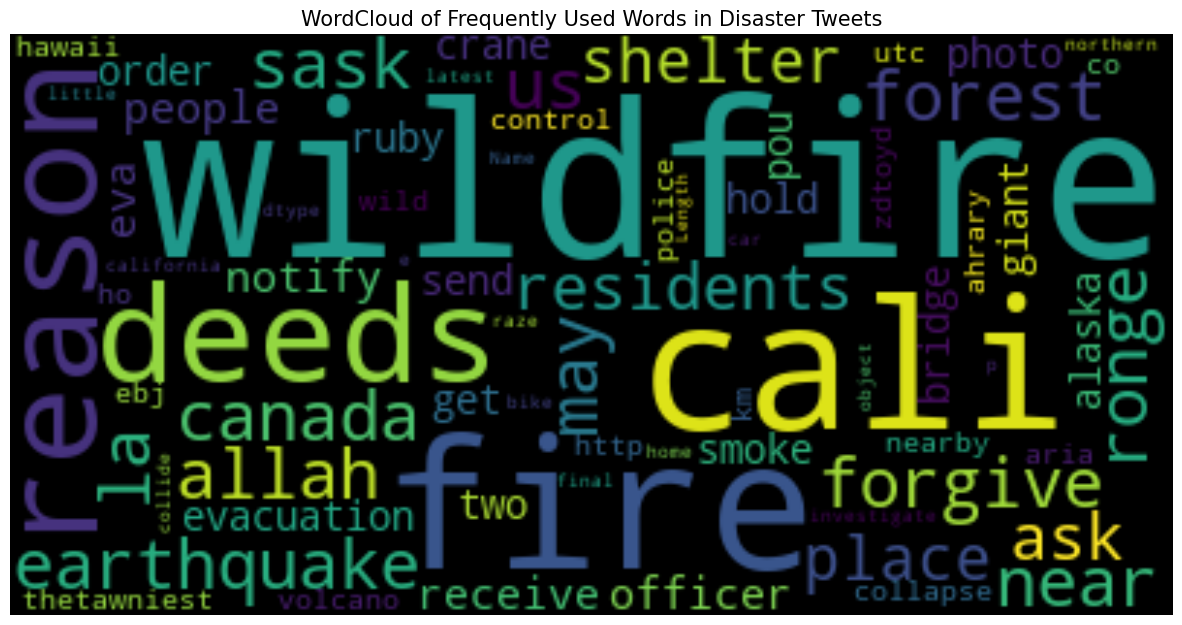

In [22]:
word_cloud_disaster = WordCloud(max_words=500, stopwords=stop_words, random_state=100, collocations=True).generate(str(disaster_df['final']))

plt.figure(figsize=(15, 10))
plt.imshow(word_cloud_disaster, interpolation='bilinear')
plt.title('WordCloud of Frequently Used Words in Disaster Tweets', fontsize=15)
plt.axis("off")
plt.show()

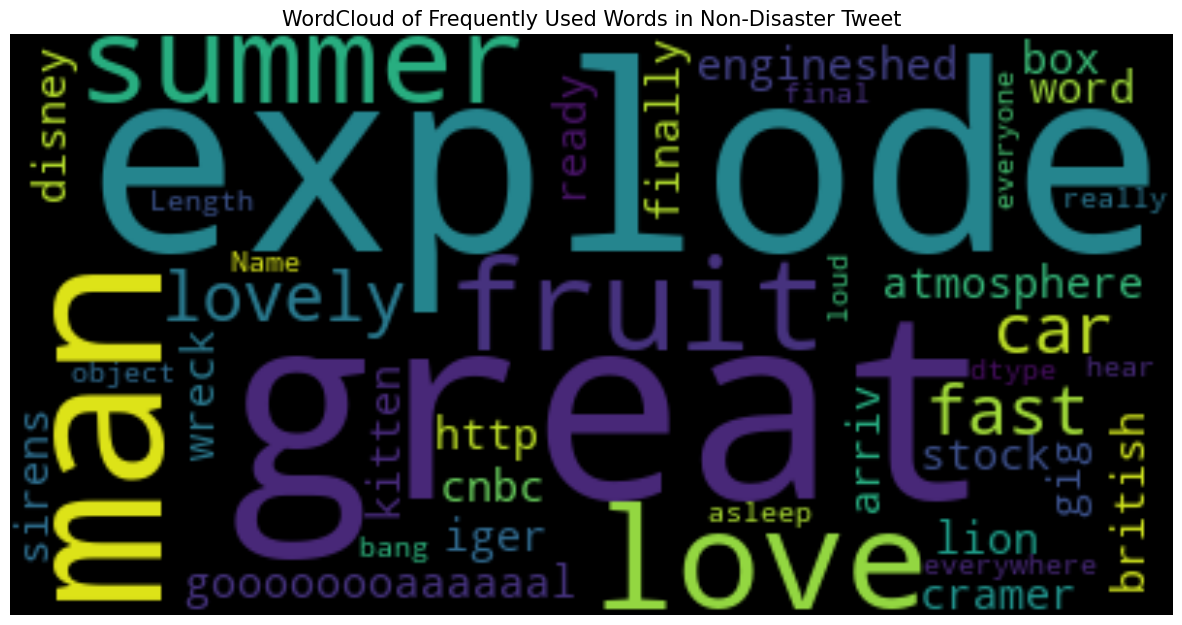

In [23]:
word_cloud_non_disaster = WordCloud(max_words=500, stopwords=stop_words, random_state=100, collocations=True).generate(str(non_disaster_df['final']))

plt.figure(figsize=(15, 10))
plt.imshow(word_cloud_non_disaster, interpolation='bilinear')
plt.title('WordCloud of Frequently Used Words in Non-Disaster Tweet', fontsize=15)
plt.axis("off")
plt.show()

## Building a Shallow Neural Network

In [24]:
X = train_df['final']
y = train_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=100)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=100)

In [25]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(4567,) (4567,)
(1523,) (1523,)
(1523,) (1523,)


In [26]:
max_tokens = 7500
output_sequence_length = 128
output_dim = 128

vectorizer_layer = TextVectorization(max_tokens=max_tokens,
                                     output_mode='int',
                                     standardize='lower_and_strip_punctuation',
                                     ngrams=1,
                                     output_sequence_length=output_sequence_length)
vectorizer_layer.adapt(X_train)

embedding_layer = Embedding(input_dim=max_tokens,
                            output_dim=output_dim,
                            input_length=output_sequence_length)

In [27]:
simple_lstm = Sequential()

simple_lstm.add(Input(shape=(1,), dtype=tf.string))

simple_lstm.add(vectorizer_layer)
simple_lstm.add(embedding_layer)

simple_lstm.add(LSTM(128))

simple_lstm.add(Dense(64, activation='relu'))
simple_lstm.add(Dense(1, activation='sigmoid'))

simple_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 128)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 128, 128)          960000    
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,099,905
Trainable params: 1,099,905
Non-trainable params: 0
______________________________________________

In [28]:
opt = Adam(learning_rate=0.001)
simple_lstm.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
simple_lstm.fit(X_train, y_train, epochs=5)

val_loss, val_acc = simple_lstm.evaluate(X_val, y_val)
print(f"Val set accuracy: {val_acc}")

Epoch 1/5
143/143 [==============================] - 7s 17ms/step - loss: 0.6876 - accuracy: 0.5579
Epoch 2/5
143/143 [==============================] - 2s 18ms/step - loss: 0.6868 - accuracy: 0.5597
Epoch 3/5
143/143 [==============================] - 2s 17ms/step - loss: 0.6867 - accuracy: 0.5597
Epoch 4/5
143/143 [==============================] - 2s 17ms/step - loss: 0.6865 - accuracy: 0.5597
Epoch 5/5
48/48 [==============================] - 1s 8ms/step - loss: 0.6783 - accuracy: 0.5936
Val set accuracy: 0.5935653448104858


## Build a Multilayer Bidirectional LSTM Model

In [29]:
ml_bi_lstm = Sequential()
ml_bi_lstm.add(Input(shape=(1,), dtype=tf.string))
ml_bi_lstm.add(vectorizer_layer)
ml_bi_lstm.add(embedding_layer)
ml_bi_lstm.add(Bidirectional(LSTM(64, return_sequences=True)))
ml_bi_lstm.add(Bidirectional(LSTM(64, return_sequences=True)))
ml_bi_lstm.add(Bidirectional(LSTM(32)))
ml_bi_lstm.add(Dropout(0.5))
ml_bi_lstm.add(Dense(32, activation='relu', kernel_regularizer=L1L2(0.001)))
ml_bi_lstm.add(Dense(16, activation='relu', kernel_regularizer=L2(0.001)))
ml_bi_lstm.add(Dropout(0.5))
ml_bi_lstm.add(Dense(8, activation='relu', kernel_regularizer=L2(0.005)))
ml_bi_lstm.add(Dense(4, activation='relu'))
ml_bi_lstm.add(Dense(1, activation='sigmoid'))

ml_bi_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 128)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 128, 128)          960000    
                                                                 
 bidirectional (Bidirectiona  (None, 128, 128)         98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128, 128)         98816     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                 

In [30]:
previous_val_accuracies = []

In [38]:
# opt = RMSprop(learning_rate=0.0001, rho=0.8, momentum=0.9)
ml_bi_lstm.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=.001), metrics=['accuracy'])
ml_bi_lstm.fit(X_train, y_train, epochs=10)

val_loss, val_acc = ml_bi_lstm.evaluate(X_val, y_val)
previous_val_accuracies.append(val_acc)
print(previous_val_accuracies[:-1])
print(f"Current iteration validation set accuracy: {val_acc}")

Epoch 1/10


c:\Users\cisco\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


143/143 [==============================] - 14s 58ms/step - loss: 0.8813 - accuracy: 0.5513
Epoch 2/10
143/143 [==============================] - 8s 59ms/step - loss: 0.7198 - accuracy: 0.5597
Epoch 3/10
143/143 [==============================] - 8s 59ms/step - loss: 0.6933 - accuracy: 0.5597
Epoch 4/10
143/143 [==============================] - 9s 59ms/step - loss: 0.6884 - accuracy: 0.5597
Epoch 5/10
143/143 [==============================] - 8s 57ms/step - loss: 0.6869 - accuracy: 0.5597
Epoch 6/10
143/143 [==============================] - 8s 57ms/step - loss: 0.6865 - accuracy: 0.5597
Epoch 7/10
143/143 [==============================] - 8s 57ms/step - loss: 0.6863 - accuracy: 0.5597
Epoch 8/10
143/143 [==============================] - 9s 61ms/step - loss: 0.6864 - accuracy: 0.5597
Epoch 9/10
143/143 [==============================] - 8s 58ms/step - loss: 0.6863 - accuracy: 0.5597
Epoch 10/10
48/48 [==============================] - 3s 28ms/step - loss: 0.6781 - accuracy: 0.5936
[

In [39]:
test_loss, test_acc = ml_bi_lstm.evaluate(X_test, y_test)

print(f"Test set accuracy: {test_acc}")

48/48 [==============================] - 2s 32ms/step - loss: 0.6816 - accuracy: 0.5791
Test set accuracy: 0.5791201591491699


## Building a Transformer Model

In [40]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [41]:
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
val_encodings = tokenizer(list(X_val), truncation=True, padding=True)

In [42]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    tf.constant(y_train, dtype=tf.int32)
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    tf.constant(y_val, dtype=tf.int32)
))

train_dataset = train_dataset.shuffle(len(X_train)).batch(16)
val_dataset = val_dataset.batch(16)

In [43]:
model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5)
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model.fit(train_dataset, epochs=10, validation_data=val_dataset)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
286/286 [==============================] - 55s 140ms/step - loss: 0.4944 - accuracy: 0.7703 - val_loss: 0.4060 - val_accuracy: 0.8418
Epoch 2/10
286/286 [==============================] - 37s 131ms/step - loss: 0.3831 - accuracy: 0.8465 - val_loss: 0.4754 - val_accuracy: 0.7827
Epoch 3/10
286/286 [==============================] - 37s 130ms/step - loss: 0.2782 - accuracy: 0.8899 - val_loss: 0.4632 - val_accuracy: 0.8378
Epoch 4/10
286/286 [==============================] - 37s 131ms/step - loss: 0.1919 - accuracy: 0.9273 - val_loss: 0.6783 - val_accuracy: 0.7991
Epoch 5/10
286/286 [==============================] - 38s 133ms/step - loss: 0.1513 - accuracy: 0.9453 - val_loss: 0.6251 - val_accuracy: 0.8148
Epoch 6/10
286/286 [==============================] - 38s 132ms/step - loss: 0.0965 - accuracy: 0.9645 - val_loss: 0.6909 - val_accuracy: 0.8267
Epoch 7/10
286/286 [==============================] - 38s 133ms/step - loss: 0.0822 - accuracy: 0.9698 - val_loss: 0.6646 - val_ac

# Conclusion

In this project, we built several deep learning text classification models using Tensorflow. We used a real-world tweets dataset to predict whether a tweet indicated disaster or not.

We started with a shallow neural network and went all the way to build Transformer based models. The performance of these various models is summarized below:

- Shallow Neural Network: Train and test set accuracy of around 58%

- Multi-layer deep text classification model: Train set accuracy of 92% and test set accuracy of 80%

- Multilayer Bidirectional LSTM Model: Train set accuracy of 99% and test set accuracy of 73%%

- Transformer Model: Train set accuracy of around 98% and validation set accuracy of around 80%

We can see that the model performance is quite good for all the model variants, except the shallow neural network one. The best performance comes from the transformer model where both the training and test set accuracy is over 98%, and there is not much difference in their accuracies, indicating that the model is consistent across train and test sets, which is a good indication.

## Possible Next Steps
Here are some next steps we can take with this model:

1. Hyperparameter Optimization: Tweak those hyperparameters like learning rate and number of layers to find the sweet spot for your deep learning model. Experiment and see how it affects the model's accuracy.

2. Optimizers and Loss Functions: Switch up the optimizers and loss functions you're using. Sometimes, a simple change can make a big difference in improving your model's performance.

3. Pretrained Transformer Models: Hey, why not try out some of the other Transformer models available instead of sticking to the classic distilbert-base-uncased? There's a whole world of possibilities out there.

4. Performance Metrics: Accuracy is great, but there are other performance metrics you can explore to get a more nuanced view of your model's strengths and weaknesses. Don't be afraid to play around and see what works best for your specific case.

5. Domain Specific Knowledge: If you have some domain-specific knowledge, don't hesitate to use it! Incorporating that expertise into your model can give it an extra boost and improve accuracy even more.

In [ ]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0']


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))